In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
!pip install gymnasium

DEPRECATION: Loading egg at /home/andrea/miniconda3/lib/python3.12/site-packages/pyglet-1.5.27-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/andrea/miniconda3/lib/python3.12/site-packages/gym_notices-0.0.8-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/andrea/miniconda3/lib/python3.12/site-packages/gym-0.26.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque

import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
env_id = "CartPole-v1"

# Create the envs
env = gym.make(env_id)
eval_env = gym.make(env_id, render_mode="rgb_array")

# Get the state space and action space
n_actions = env.action_space.n

In [6]:
class Policy(nn.Module):
    def __init__(self, state_size, n_actions, hidden_size, device=torch.device('cpu')):
        super(Policy, self).__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        self.device = device

    def forward(self, x):
        # Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

    def act(self, state, exploration=True):
        # Get Action Probabilities
        probs = self.forward(state).cpu()

        # Return Action and LogProb
        action = probs.argmax(-1)
        log_prob = None
        if exploration:
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
        return action.item(), log_prob

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret

In [7]:
def evaluate_agent(env, n_eval_episodes, policy):
    episode_rewards = []

    for episode in range(n_eval_episodes):
        state, _ = env.reset() # state reset
        done = trunc = False

        # stats
        total_rewards_ep = 0

        while not done and not trunc:
            # perform action
            action, _ = policy.act(torch.tensor(state).to(device), exploration=False)

            state, reward, done, trunc, _ = env.step(action)

            # stats
            total_rewards_ep += reward

        # stats
        episode_rewards.append(total_rewards_ep)

    # stats
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [8]:
def reinforce(policy, optimizer, n_training_episodes=50, gamma=0.99, print_every=10, target_eval_score=500):
    # stats
    scores_deque = deque(maxlen=100)

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = [] # stores log probs during episode
        rewards = [] # stores rewards during episode

        # init episode
        state, _ = env.reset()
        done = trunc = False

        while not done and not trunc:
            action, log_prob = policy.act(torch.tensor(state).to(device))

            saved_log_probs.append(log_prob)

            state, reward, done, trunc, _ = env.step(action)

            rewards.append(reward)

        scores_deque.append(sum(rewards))

        rewards = np.array(rewards)
        discounts = np.power(gamma, np.arange(len(rewards)))

        policy_loss = 0
        for t in range(len(rewards)):
            G = (discounts[:len(rewards)-t]*rewards[t:]).sum()
            policy_loss += -(gamma**t)*G*saved_log_probs[t]

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            eval_score = evaluate_agent(eval_env,5,policy)
            print(f'''Episode {i_episode}
                    \tAverage Score: {np.mean(scores_deque)}
                    \tLast Score: {rewards.sum()}
                    \tEval Score: {eval_score[0]}''')
            torch.save(policy, 'model.pt')
            if eval_score[0] >= target_eval_score:
                print(f"Environment solved in {i_episode} episodes!")
                break
        


In [9]:
policy = Policy(env.observation_space.shape[0], n_actions, 32).to(device)
policy = policy.to(device)

In [10]:
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [11]:
reinforce(policy, optimizer, n_training_episodes=700)

Episode 10
                    	Average Score: 22.2
                    	Last Score: 52.0
                    	Eval Score: 9.0
Episode 20
                    	Average Score: 19.35
                    	Last Score: 14.0
                    	Eval Score: 10.6
Episode 30
                    	Average Score: 21.5
                    	Last Score: 22.0
                    	Eval Score: 14.0
Episode 40
                    	Average Score: 23.175
                    	Last Score: 43.0
                    	Eval Score: 16.6
Episode 50
                    	Average Score: 23.26
                    	Last Score: 14.0
                    	Eval Score: 19.0
Episode 60
                    	Average Score: 24.316666666666666
                    	Last Score: 39.0
                    	Eval Score: 20.0
Episode 70
                    	Average Score: 24.242857142857144
                    	Last Score: 9.0
                    	Eval Score: 24.6
Episode 80
                    	Average Score: 25.35
                    	

In [12]:
policy.device

device(type='cuda', index=0)

# Test

In [13]:
policy = torch.load('model.pt', map_location=device)
policy = policy.to(device)
policy.eval()

/tmp/ipykernel_38926/2062629924.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy = torch.load('model.pt', map_location=device)


Policy(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [14]:
from matplotlib import animation
import matplotlib.pyplot as plt

def save_frames_as_gif(frames, path='./', filename='REINFORCE.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [15]:
def play_agent(env, policy):
    total_reward = 0
    state, _ = env.reset()
    frames_gif=[]
    step = 0
    done = trunc = False
    while not done and not trunc:
        action, _ = policy.act(torch.tensor(state).to(device), exploration=False)
        new_state, reward, done, trunc, _ = env.step(action)
        total_reward += reward
        frames_gif.append(env.render())
        state = new_state
    save_frames_as_gif(frames_gif)
    print("Total Reward:", total_reward)

Total Reward: 500.0


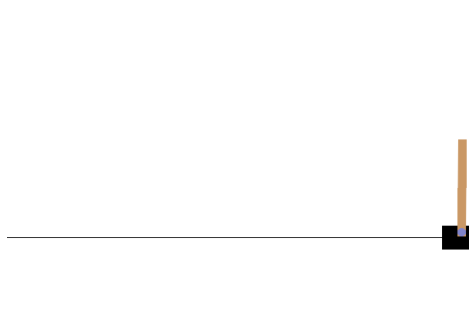

In [16]:
play_agent(eval_env, policy)